In [31]:
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score


In [18]:
# Create the database connection
con = duckdb.connect(".config/nfl.duckdb")

In [19]:
# Creating dataframes with DuckDB
df = con.sql("""
    SELECT *
    FROM gold.plays_numeric
""").df()

df.head()

,gameId,playId,possessionTeam,offenseFormation,receiverAlignment,playType,yardsGained,playOutcome
0,2022102302,2655,CIN,3,8,2,9,3
1,2022091809,3698,CIN,3,8,2,4,3
2,2022103004,3146,HOU,6,5,2,6,3
3,2022110610,348,KC,6,5,2,4,3
4,2022102700,2799,BAL,4,7,1,-1,2


In [26]:
# Splitting the data into X and y, then doing train_test_split
# For y, fetchnumpy() is currently broken with DuckDB, so instead, need to use a combo of np/duckdb methods to get a flat array
X = con.sql("""
    SELECT offenseFormation, receiverAlignment, playType, yardsGained
    FROM gold.plays_numeric            
""").df()
y = np.array(con.sql("""
    SELECT playOutcome
    FROM gold.plays_numeric            
""").df()).ravel()

print(X.shape, y.shape)

(16124, 4) (16124,)


In [27]:
# Instantiate the LinearRegression object, split the data into train and testing
#linreg = LinearRegression()
knn = KNeighborsClassifier(n_neighbors=5)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=123)

In [28]:
# Fit the model
#linreg.fit(X_train, y_train)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [19]:
print("Coefficients:", linreg.coef_)  # Feature weights
print("Intercept:", linreg.intercept_)  # Bias term


Coefficients: [[-0.02379523 -0.01926485  2.19247338 -0.01409383]]
Intercept: [-0.83843291]


In [29]:
# KNN Performance Metrics
y_pred = knn.predict(X_val)

print(knn.score(X_val, y_val))

0.9346837536171972


In [30]:
# Datacamp Model performance Loop
# Create neighbors
neighbors = np.arange(1, 13)
train_accuracies = {}
test_accuracies = {}

for neighbor in neighbors:
  
	# Set up a KNN Classifier
	knn = KNeighborsClassifier(n_neighbors=neighbor)
  
	# Fit the model
	knn.fit(X_train, y_train)
  
	# Compute accuracy
	train_accuracies[neighbor] = knn.score(X_train, y_train)
	test_accuracies[neighbor] = knn.score(X_val, y_val)
print(neighbors, '\n', train_accuracies, '\n', test_accuracies)

[ 1  2  3  4  5  6  7  8  9 10 11 12] 
 {np.int64(1): 0.9209640262271841, np.int64(2): 0.9137869927343611, np.int64(3): 0.9375332270069112, np.int64(4): 0.9318624844940634, np.int64(5): 0.9355839092681197, np.int64(6): 0.9340776182881446, np.int64(7): 0.9324827219564061, np.int64(8): 0.9315966684387738, np.int64(9): 0.9294701399964558, np.int64(10): 0.929913166755272, np.int64(11): 0.9274322169059012, np.int64(12): 0.9265461633882687} 
 {np.int64(1): 0.9107069036792063, np.int64(2): 0.9030591153369161, np.int64(3): 0.9336502687060769, np.int64(4): 0.9288962381149235, np.int64(5): 0.9346837536171972, np.int64(6): 0.9326167837949566, np.int64(7): 0.9311699049193882, np.int64(8): 0.93075651095494, np.int64(9): 0.9311699049193882, np.int64(10): 0.9299297230260438, np.int64(11): 0.9286895411326994, np.int64(12): 0.9280694501860273}


In [ ]:
# Linear regression performance metrics
y_pred = linreg.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mse)

print("MSE: ", mse)
print("R2: ", r2)
print("Root Mean Squared Error:", rmse)


MSE:  0.49086621459513724
R2:  0.7016465290166432
Root Mean Squared Error: 0.7006184515091914


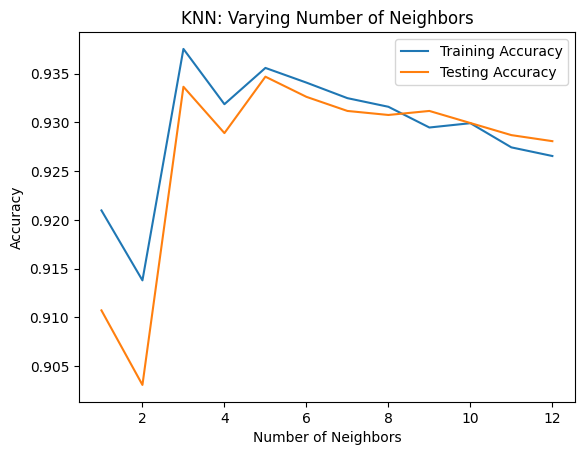

In [32]:
# Add a title
plt.title("KNN: Varying Number of Neighbors")

# Plot training accuracies
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")

# Plot test accuracies
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")

# Display the plot
plt.show()